In [1]:
import numpy as np
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import itertools
from copy import deepcopy as dcopy,copy
from skimage.morphology import label
from scipy.signal import convolve2d
from scipy.ndimage import measurements

In [4]:
# Working through the hooks puzzles.
# 
# Coming back and reusing code from hooks 6
# Determine the valid hook placements
# then loop through the rows and columns to determine forced cells 
# if these are mismatched on the row and column loop flag as inconsistent
# then solve the final grid with backtracking

url='https://www.janestreet.com/puzzles/hooks-5/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
x =[text for text in soup.body.stripped_strings]

print(" ".join(x[7:11]))

The grid presented here can be partitioned into 9 L-shaped “hooks”. The largest is 9-by-9 (contains 17 squares), the next largest is 8-by-8 (contains 15 squares), and so on. The smallest hook is just a single square. Find where the hooks are located, and place nine 9’s in the largest hook, eight 8’s in the next-largest, etc., down to one 1 in the smallest hook. The filled squares must form a connected region. (Squares are “connected” if they are orthogonally adjacent.) A number outside the grid indicates the sum of the first consecutive block of filled squares when looking in that direction. (As shown in the example.) Furthermore, every 2-by-2 region must contain at least one unfilled square. The answer to this puzzle is the product of the areas of the connected groups of empty squares in the completed grid.


### Puzzle details
<img src="https://www.janestreet.com/puzzles/hooks_5.png" width="300" height="300">

In [2]:
#Setup the constraints
top_labels  = [41, 8, 0, 0,14, 0,15, 0, 0]
bot_labels  = [ 0, 9, 0,17, 0,15, 0,35, 0]
left_labels = [ 0, 0,25, 0,15, 0,26, 0, 0]
right_labels =[25, 0, 0, 0,10, 0, 0, 0,27]

In [3]:
class Matrix():
    def __init__(self,top_labels,bot_labels,left_labels,right_labels):
        self.top_labels = top_labels
        self.bot_labels = bot_labels
        self.left_labels = left_labels
        self.right_labels = right_labels
        self.potential_grids = [[-9,np.ones((9,9),dtype=int)*-1,[0,0,9,9]]] # list of all grids not yet ruled out.[Level,grid,coordinates of the grid yet to be filled]
        self.solution = []
        self.splits =  [list(i) for i in itertools.product([0, 1], repeat=9)]
        self.end_flag =0
     
    ########################################################################################
    # Code to get the initial valid grids

    def add_layer(self,grid,coords,lvl,alignment):
        row_start,col_start,row_end, col_end = coords
    
        if alignment == 0:
            grid[row_start:row_end,col_start] =lvl
            grid[row_start,col_start:col_end] =lvl
            row_start +=1
            col_start +=1
    
        elif alignment == 1:
            grid[row_start:row_end,col_start] =lvl
            grid[row_end-1,col_start:col_end] =lvl
            row_end -=1
            col_start +=1 

        elif alignment == 2:
            grid[row_start:row_end,col_end-1] =lvl
            grid[row_start,col_start:col_end] =lvl
            row_start +=1
            col_end -=1
        
        else: # alignment == 3:
            grid[row_start:row_end,col_end-1] =lvl
            grid[row_end-1,col_start:col_end] =lvl
            row_end -=1
            col_end -=1 
    
        coords = [row_start,col_start,row_end, col_end]
        
        return grid,coords    
   
    def check_grid(self,grid):
        for i in range(9):
            row = grid[i,:]
            col = grid[:,i]
            if -1 not in row:
                    if not self.check_line(row,self.left_labels[i],self.right_labels[i]):
                        return False
            if -1 not in col:
                    if not self.check_line(col,self.top_labels[i],self.bot_labels[i]):
                        return False
                              
        return True
                    
    def check_line(self,line,param_start,param_end):
        for split in self.splits:
            test = line * split
            if self.valid_line(test,param_start):
                if self.valid_line(test[::-1],param_end):
                    return 1
        return 0
    

    def valid_line(self,pos,param):
        if param == 0:
            return True
        total = 0 
        block = 0
        inblock =0
        for p in pos:
            if p !=0:
                block += p
                inblock = 1
            else:
                if inblock == 1:
                    total += block
                    block = 1
                    break
                    
        if block > 1:
            total +=block
        if total == param:
            return True
        else:
            return False
     
     #########################################################
    # Code to get the cells forced by the params
    # for rows and cols loop through the possible lines and see which are 
    # common to all the splits
    # compare the 2 different forced matricies, if there are inconsistencies 
    # first value returned is zero and it's flagged as inconsistent
    
    def forced_cells(self,hook):
        row_force = np.ones((9,9),dtype=int)*-1
        col_force = dcopy(row_force)
        # loop through the params to determine forced cells
        for i in range(9):
            row_force[i,:] = self.forced_line(hook[i,:],self.left_labels[i],self.right_labels[i])

        for i in range(9):
            col_force[:,i] = self.forced_line(hook[:,i],self.top_labels[i],self.bot_labels[i])
        
   
        final = np.ones((9,9),dtype=int)*-1
        
        # look at the 2 different versions of the matrices and combine
        for i,j in itertools.product(range(9),range(9)):
            options = np.array([row_force[i,j],col_force[i,j]])
            if (np.any(options==1)) & (np.all(options !=0)):
                final[i,j] = 1
            
            if (np.any(options==0)) & (np.all(options !=1)):
                final[i,j] = 0
            #flag inconsistent forced matrices    
            if (np.any(options==1)) & (np.any(options==0)):
                return 0,final
        #print(options,"=>",final[i,j])
        
        
        # set the cell with 1 in as 1 then loop through and fill in cells neeeded to ensure connectivity 
        final[hook==1] =1
        changes =1
        while changes >0:

            changes = 0
    
            for i,j in itertools.product(range(9),range(9)):
                if final[i,j] == -1:
                    test =final*hook
                    test[i,j] = 0
                    if np.max(label(test!=0,connectivity=1)) > 1:
                    #if placing zero would break connectivity set 1
                        final[i,j]=1
                        changes =1
        
        return  1,final
      
    def forced_line(self,line,param_start,param_end):
        poss_line =[]
        for split in self.splits:
            test = line * split
            if self.valid_line(test,param_start):
                if self.valid_line(test[::-1],param_end):
                    poss_line.append(split)
        poss_array = np.array(poss_line)
        forced = np.ones(9,dtype=int)*-1
        for i in range(9):
            if np.all(poss_array[:,i]==1):
                forced[i] =1
            elif np.all(poss_array[:,i]==0):
                forced[i] =0
        return forced
    
   
    
    #########################################################
    # Fill the final cells by backtracking
        
        
    def fill_rest(self,grid,hooks):
        for col,row in itertools.product(range(9),range(9)):
            if grid[row,col]==-1:
                for digit in range(2):
                    if self.possible(digit,row,col,grid,hooks):
                        grid[row,col] = digit
                        self.fill_rest(grid,hooks)
                        grid[row,col] = -1
                return
        sol_print(grid,hooks)
        print("The product of the areas is : {:,.0f}".format(self.areas(grid)))
        self.end_flag =1                        
                            
    def possible(self,digit,row,col,grid,hooks):
        test = grid*hooks
        test[row,col] = hooks[row,col]*digit

    
    #check the placement doesn't break connectivity
        if np.max(label(test!=0,connectivity=1)) > 1:
            return False
        
    #check the placement doesn't break 2 by 2
        if self.twobytwo(test):
            return False
    
     #check the placement doesn't exceed the permitted count of that number
        for num in range(2,10):
            if np.sum(test == num) > num:
                   return False
                
        #check rows and columns
        for i in range(9):
            row = test[i,:]
            col = test[:,i]
            if np.all(row>-1):
                if not self.valid_line(row,self.left_labels[i]):
                    return False
                if not self.valid_line(row[::-1],self.right_labels[i]):
                    return False

                
            if np.all(col>-1):
                if not self.valid_line(col,self.top_labels[i]):
                    return False
                if not self.valid_line(col[::-1],self.bot_labels[i]):
                    return False
    
        
    # final checks if the placement completes the grid    
        if np.sum(grid == -1) ==1:
        #check counts again
            for i in range(2,10):
                if np.sum(test == i) != i:
                    return False
      
        return True
        
    def twobytwo(self, grid):
        return np.any(convolve2d(grid > 0, np.ones((2, 2)), mode='valid') == 4)
    
    ##############################################
    # Get the products of the areas of the connected cells
    
    def areas(self,grid):
        labels, num = measurements.label(np.logical_not(grid!=0))
        areas = measurements.sum(np.logical_not(grid!=0), labels, index=range(1, num+1))

        return np.prod(areas)
    
    ###############################################
    # Main solver.
    
    def solve(self):
           
        while len(self.potential_grids) > 0:
            
            temp_grid = self.potential_grids.pop(0)
            #create the potential rotations at the given level
            rotations = []
        
            for alignment in range(4):
                lvl,grid,coords = dcopy(temp_grid)
                grid,coords = self.add_layer(grid,coords,-lvl,alignment)
                if lvl != -1 :
                    rotations.append([lvl+1,grid,coords])
                else:
                     rotations = [[lvl+1,grid,coords]]
    
            #check valid grids (where the sum can be made from available digits) and save the ones that work
            for i in range(len(rotations)):
                lvl,g,coords = rotations[i]
                if self.check_grid(g):
                    if lvl !=0:    
                        self.potential_grids.append([lvl,g,coords])
                    else:
                        self.solution.append(g)
                        


                        
        print("There are {} valid hook placements".format(len(self.solution)))

        #solve each grid in the cut down list
        forced_grids = []
        for i in range(len(self.solution)):
            #print("Checking: ",i+1)
            if self.end_flag == 0:
                hooks = self.solution[i]
                flag,forced_grid = self.forced_cells(hooks)
                if flag:
                    #for valid forced grids solve the final matrix
                    print("Grid # ",i,"still to solve",np.sum(forced_grid==-1))
                    self.fill_rest(forced_grid,hooks)
                #else:
                    #print("***INCONSISTENT***")
            
        
#########################
# Code to print in a "nice" format
                            
def sol_print(solved,matrix):
    fig,ax = plt.subplots(1,1,figsize=(4,4))
    x = np.array((solved*matrix).astype('int').astype('str'))
    x[x=="0"] ="-"
    ax = sns.heatmap(matrix,annot=x,cbar=False,cmap="Set3_r",fmt="",linewidths=0.25)
    ax.axis("off")

There are 135 valid hook placements
Grid #  28 still to solve 43


/var/folders/gh/y4xlwd0d05xc91xhsql5lf0w0000gn/T/ipykernel_10372/1397559201.py:230: DeprecationWarning: Please use `label` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  labels, num = measurements.label(np.logical_not(grid!=0))
/var/folders/gh/y4xlwd0d05xc91xhsql5lf0w0000gn/T/ipykernel_10372/1397559201.py:231: DeprecationWarning: Please use `sum` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  areas = measurements.sum(np.logical_not(grid!=0), labels, index=range(1, num+1))


The product of the areas is : 78,125

 Solution took 3.9835 seconds



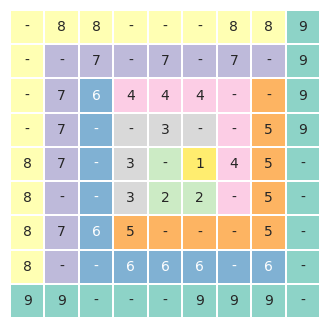

In [4]:
start = time.perf_counter()
test = Matrix(top_labels,bot_labels,left_labels,right_labels)
test.solve()
stop =  time.perf_counter()
print('\n Solution took {:0.4f} seconds\n'.format((stop-start)))

In [8]:
url='https://www.janestreet.com/puzzles/solutions/june-2019-solution/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
x =[text for text in soup.body.stripped_strings]

print(" ".join(x[7:9]))

The completed grid is shown to the left, and the product of the areas of the empty regions is 78125


### Puzzle solution
<img src="https://www.janestreet.com/puzzles/20190701_hooks_5_sol.png" width="250" height="400">